In [1]:
import requests
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from matplotlib.pyplot import figure
import scipy.stats as st

In [2]:
# USE THIS DOCUMENTATION! IT'S MUCH BETTER:
# https://github.com/COEJKnight/five/blob/0777303f4bee60a10afaccbd0f5c56d880ad0059/usaspending_api/api_docs/api_documentation/advanced_award_search/spending_by_geography.md

In [3]:
# Don't change this
headers={'Content-Type':'application/json'}
url="https://api.usaspending.gov/api/v2/search/spending_by_geography/"
body = []
responses = []

#NOTE data not available before 2007. 
years = [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
#Do change this, depending on the filters that you want to apply (refer to the documentation link above to understand the parameters and output)
for year in years:
    body.append({
            "scope": "place_of_performance",
            "geo_layer": "state",
            #"geo_layer_filters":["MD","VA"],
            "filters": {
                "time_period": [
                    {
                        "start_date": f"{year}-10-01",
                        "end_date": f"{(year+1)}-09-30"
                    }
                    ]}
        })
#body[0] is equivalent to the object returned for year 0 which is 2001

In [4]:
#This is where we make the actual request to the API
for body in body:
    responses.append(requests.post(url, data=json.dumps(body),headers=headers).json())

#responses[0] is equivalent to body[0] which is equivalent to year[0]

In [5]:
# we need to build dataframe, keyed with the years list then enter the responses.json, 
# pull aggregated amount for each relevant state plus shape code(to check) 
# use for loop to get each state's info into list, then concatenate. 

aggregates =[]
counter = 0

for year in years:
    dataframe = pd.DataFrame(responses[counter]["results"])
    dataframe["year"] = year
    aggregates.append(dataframe)
    counter+=1

# Pulls aggregates list into single DF and rounds spend column

agg_full = pd.concat(aggregates).reset_index(drop=True)
agg_full["agg_billions"] = (agg_full["aggregated_amount"]/1000000000).round(decimals=3)
agg_full.drop(columns="aggregated_amount", inplace=True)
agg_full

,shape_code,display_name,year,agg_billions
0,AE,None,2007,0.001
1,AK,Alaska,2007,4.124
2,AL,Alabama,2007,23.321
3,AR,Arkansas,2007,9.320
4,AS,American Samoa,2007,0.119
...,...,...,...,...
713,VT,Vermont,2018,5.727
714,WA,Washington,2018,66.253
715,WI,Wisconsin,2018,93.871
716,WV,West Virginia,2018,18.009


In [6]:
################# Senator Class Analysis #################

# Source: https://en.wikipedia.org/wiki/Classes_of_United_States_senators
# Note there is redundancy between the classes, because each state has two Senators.
# Establish election years by class.

class_1_str = "Arizona, California, Connecticut, Delaware, Florida, Hawaii, Indiana, Maine, Maryland, Massachusetts, Michigan, Minnesota, Mississippi, Missouri, Montana, Nebraska, Nevada, New Jersey, New Mexico, New York, North Dakota, Ohio, Pennsylvania, Rhode Island, Tennessee, Texas, Utah, Vermont, Virginia, Washington, West Virginia, Wisconsin, Wyoming"
class_2_str = "Alabama, Alaska, Arkansas, Colorado, Delaware, Georgia, Idaho, Illinois, Iowa, Kansas, Kentucky, Louisiana, Maine, Massachusetts, Michigan, Minnesota, Mississippi, Montana, Nebraska, New Hampshire, New Jersey, New Mexico, North Carolina, Oklahoma, Oregon, Rhode Island, South Carolina, South Dakota, Tennessee, Texas, Virginia, West Virginia, Wyoming"
class_3_str = "Alabama, Alaska, Arizona, Arkansas, California, Colorado, Connecticut, Florida, Georgia, Hawaii, Idaho, Illinois, Indiana, Iowa, Kansas, Kentucky, Louisiana, Maryland, Missouri, Nevada, New Hampshire, New York, North Carolina, North Dakota, Ohio, Oklahoma, Oregon, Pennsylvania, South Carolina, South Dakota, Utah, Vermont, Washington, Wisconsin"

def list_split(string):
    output = list(string.split(", "))
    return output

class_1 = list_split(class_1_str)
class_2 = list_split(class_2_str)
class_3 = list_split(class_3_str)

us_state_abrv = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Palau': 'PW',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY',
}
class_1_abrv = [(us_state_abrv[state]) for state in class_1]
class_2_abrv = [(us_state_abrv[state]) for state in class_2]
class_3_abrv = [(us_state_abrv[state]) for state in class_3]

class_1_years = [2018, 2012,2006] #blue
class_2_years = [2020, 2014,2008] #orange
class_3_years = [2016, 2010] #green

# print(class_1_abrv,class_2_abrv,class_3_abrv)

In [7]:
# Establish aggregate amounts by class. "In YEAR Class 1 had this amount of aggregate spend, in YEAR+1, etc"
agg_full["class_1"] = agg_full["shape_code"].isin(class_1_abrv)
agg_full["class_2"] = agg_full["shape_code"].isin(class_2_abrv)
agg_full["class_3"] = agg_full["shape_code"].isin(class_3_abrv)

agg_full

,shape_code,display_name,year,agg_billions,class_1,class_2,class_3
0,AE,None,2007,0.001,False,False,False
1,AK,Alaska,2007,4.124,False,True,True
2,AL,Alabama,2007,23.321,False,True,True
3,AR,Arkansas,2007,9.320,False,True,True
4,AS,American Samoa,2007,0.119,False,False,False
...,...,...,...,...,...,...,...
713,VT,Vermont,2018,5.727,True,False,True
714,WA,Washington,2018,66.253,True,False,True
715,WI,Wisconsin,2018,93.871,True,False,True
716,WV,West Virginia,2018,18.009,True,True,False


In [8]:
# Create DF of aggregate spend by CLASS
# COULD ADD CHANGE HERE, AS WE DO BELOW FOR TOTAL AND YEAR

class1_grp = agg_full.loc[agg_full["class_1"] == True].reset_index().groupby("year")
class2_grp = agg_full.loc[agg_full["class_2"] == True].reset_index().groupby("year")
class3_grp = agg_full.loc[agg_full["class_3"] == True].reset_index().groupby("year")

class_df = pd.DataFrame()
class_df["class_1_agg_billions"] = class1_grp["agg_billions"].sum()
class_df["class_2_agg_billions"] = class2_grp["agg_billions"].sum()
class_df["class_3_agg_billions"] = class3_grp["agg_billions"].sum()

class_df

,class_1_agg_billions,class_2_agg_billions,class_3_agg_billions
year,,,
2007,917.677,631.878,816.767
2008,1651.561,1131.663,1566.156
2009,1513.885,1041.839,1424.390
2010,2328.022,1477.293,2180.003
2011,2333.330,1483.519,2187.149
2012,2413.305,1493.109,2250.424
2013,1467.238,992.224,1371.906
2014,2047.382,1244.146,1982.538
2015,2184.982,1342.237,2127.001


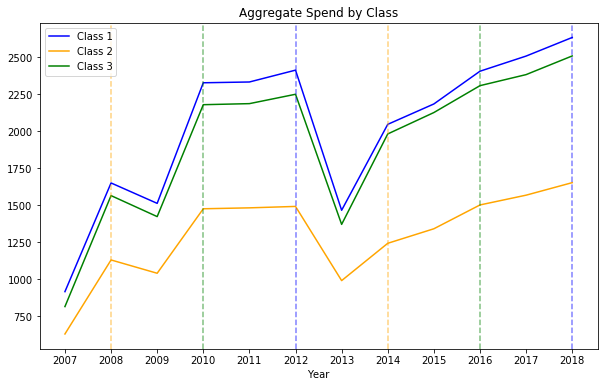

In [9]:
# Plot aggregate spend by class, noting election years

plt.figure(figsize=(10,6))
plt.plot(class_df["class_1_agg_billions"], label="Class 1", color="blue")
plt.plot(class_df["class_2_agg_billions"], label="Class 2", color="orange")
plt.plot(class_df["class_3_agg_billions"], label="Class 3", color="green")
plt.xticks(years)
plt.xlabel("Year")
plt.title("Aggregate Spend by Class")
plt.legend()

# defines a function to add lines to election graphs
def election_lines(classes):
    for item in classes: 
        for check in classes:
            if(check != 1 and check != 2 and check != 3):
                print(f"Election class selection error. {check} is not a supported class. Please input with number(s) 1-3")
                return
        if(item == 1):
            plt.axvline(x=2012, color="blue", alpha=.50, linestyle="--")
            plt.axvline(x=2018, color="blue", alpha=.50, linestyle="--")
        elif(item == 2):
            plt.axvline(x=2008, color="orange", alpha=.50, linestyle="--")
            plt.axvline(x=2014, color="orange", alpha=.50, linestyle="--")
        elif(item == 3):
            plt.axvline(x=2010, color="green", alpha=.50, linestyle="--")
            plt.axvline(x=2016, color="green", alpha=.50, linestyle="--")

election_lines([1,2,3])
plt.show()

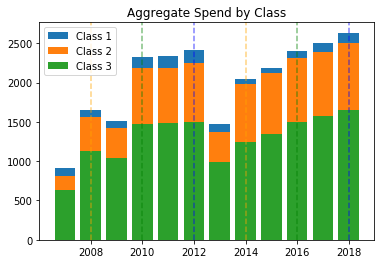

In [29]:
# Stacked bar of classes by proportion of total spend
reset_class_df = class_df.reset_index()
plt.bar(reset_class_df['year'], reset_class_df['class_1_agg_billions'], label='Class 1')
plt.bar(reset_class_df['year'], reset_class_df['class_3_agg_billions'], label='Class 2')
plt.bar(reset_class_df['year'], reset_class_df['class_2_agg_billions'], label='Class 3')
plt.title("Aggregate Spend by Class")
plt.legend()

election_lines([1,2,3])
plt.show()

In [11]:
################# Aggregate Spend/Change Analysis #################

year_group = agg_full.groupby("year")
fed_spend=pd.DataFrame()
fed_spend["Agg Spend: 100s of Billions"] = round(year_group["agg_billions"].sum()/100,2)

counter = 0
tracker = 0.0
change = []
perc_change = []

for amount in fed_spend["Agg Spend: 100s of Billions"]:
    if counter == 0:
        change.append(0)
        perc_change.append(0)
        counter+=1
        tracker = amount
        continue

    change.append(amount - tracker)
    perc_change.append(round(change[counter]/tracker*100,2))    
    
    counter+=1
    tracker = amount

fed_spend["Change"] = change
fed_spend["% Change"] = perc_change
fed_spend["Increase?"] = fed_spend["Change"] >0
fed_spend["Election Year?"] = fed_spend.index%2 ==0

fed_spend_pretty=fed_spend.copy()
fed_spend_pretty["% Change"]=fed_spend_pretty["% Change"].map('{:,.2f}%'.format)
fed_spend_pretty["Change"]=fed_spend_pretty["Change"].map('${:,.2f}'.format)

fed_spend_pretty
# fed_spend

,Agg Spend: 100s of Billions,Change,% Change,Increase?,Election Year?
year,,,,,
2007,12.13,$0.00,0.00%,False,False
2008,22.19,$10.06,82.93%,True,True
2009,20.36,$-1.83,-8.25%,False,False
2010,30.42,$10.06,49.41%,True,True
2011,30.49,$0.07,0.23%,True,False
2012,31.22,$0.73,2.39%,True,True
2013,19.58,$-11.64,-37.28%,False,False
2014,26.88,$7.30,37.28%,True,True
2015,28.80,$1.92,7.14%,True,False


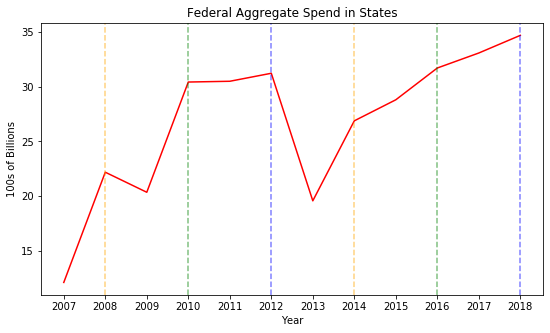

In [12]:
# showing aggregate spend graph
plt.figure(figsize=(9,5))
plt.plot(fed_spend["Agg Spend: 100s of Billions"],color="red")
plt.title("Federal Aggregate Spend in States")
plt.xticks(years)
plt.ylabel("100s of Billions")
plt.xlabel("Year")

# adds vertical lines according to class/election years
election_lines([1,2,3])

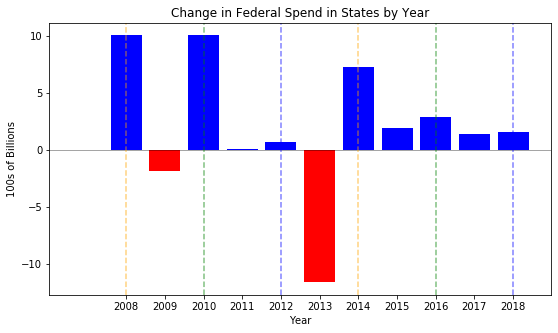

In [20]:
# Plotting CHANGE in Fed Spend/State/Year

plt.figure(figsize=(9,5))
# removed 2007 because we don't have 2006 data to note the change. 
plt.xticks(years[1:])
plt.bar(fed_spend.index, fed_spend["Change"], color= fed_spend["Increase?"].map({True: 'b', False: 'r'}))
plt.title("Change in Federal Spend in States by Year")
plt.ylabel("100s of Billions")
plt.xlabel("Year")
plt.axhline(0,color="black",alpha=.5,linewidth=.7)

election_lines([1,2,3])

In [21]:
#Calculating average rate of change for election years/nons
#Starting with outlier analysis

quartiles = fed_spend["Change"].quantile([.25,.5,.75])
lowerq = quartiles[0.25]
upperq = quartiles[0.75]
iqr = upperq-lowerq

lower_bound = lowerq - (1.5*iqr)
upper_bound = upperq + (1.5*iqr)

outliers_df = fed_spend.loc[(fed_spend["Change"] > upper_bound) | (fed_spend["Change"] < lower_bound), :]
outliers_df

,Agg Spend: 100s of Billions,Change,% Change,Increase?,Election Year?
year,,,,,
2008,22.19,10.06,82.93,True,True
2010,30.42,10.06,49.41,True,True
2013,19.58,-11.64,-37.28,False,False


In [22]:
# Calculate average change and difference for remainder

fed_no_outlier = fed_spend.drop(outliers_df.index)

is_election_clean = fed_no_outlier.groupby(["Election Year?"])
change_df = pd.DataFrame()
change_df["Average Change (Billions)"] = round(is_election_clean["Change"].mean()*100,2)

print(change_df["Average Change (Billions)"][True]-change_df["Average Change (Billions)"][False])
change_df

282.9


,Average Change (Billions)
Election Year?,
False,30.6
True,313.5


In [23]:
# Calculate rate of change and difference, including outliers.

is_election = fed_spend.groupby(["Election Year?"])
change_df_outliers = pd.DataFrame()
change_df_outliers["Average Change (Billions)"] = round(is_election["Change"].mean()*100,2)

print(change_df_outliers["Average Change (Billions)"][True]-change_df_outliers["Average Change (Billions)"][False])
change_df_outliers

712.83


,Average Change (Billions)
Election Year?,
False,-168.50
True,544.33


In [24]:
# Execute similar groupby, but noting whether specific classes perform differently on election years
# is_election_classes = fed_spend.groupby(["Election Year?",""])


Enter the abbreviations of the state(s) you would like to look up, separated by a comma then a space: KY
Any other states? Y/N N

  shape_code  Class 1 (Blue)  Class 2 (Orange)  Class 3 (Green)
0         KY           False              True             True


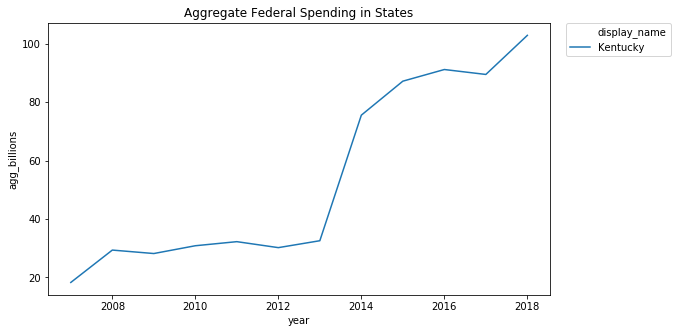

In [26]:
################ Customizeable Spending Plots by State #################

#Get responses
states_input = []
more = True
while more == True:
    input_var = input("Enter the abbreviations of the state(s) you would like to look up, separated by a comma then a space: ")
    states_input.extend(list_split(input_var))
    
    input_var = input("Any other states? Y/N ")
    if input_var == "N" or input_var == "n": more = False
print()

###Output classes DF
custom_df=pd.DataFrame()
list_of_states = []
counter=0
for state in states_input:
    list_of_states.append(agg_full.loc[agg_full["shape_code"] == states_input[counter]])
    counter+=1
custom_df = pd.concat(list_of_states).drop_duplicates(subset="shape_code").reset_index(drop=True)

custom_df.drop(columns = ["display_name", "year", "agg_billions"], inplace=True)

custom_df.rename(columns={"class_1":"Class 1 (Blue)","class_2":"Class 2 (Orange)","class_3":"Class 3 (Green)"},inplace=True)

print(custom_df)

#Prepare relevant election lines... Triggers all lines on multiple states for some reason. 
list_of_lines = []
if True in custom_df["Class 1 (Blue)"]: list_of_lines.append(1)
if True in custom_df["Class 2 (Orange)"]: list_of_lines.append(2)
if True in custom_df["Class 3 (Green)"]: list_of_lines.append(3)

###Set up plot
state_mask = agg_full["shape_code"].isin(states_input)

fig, ax = plt.subplots(figsize=(9,5))

plot = sns.lineplot(x="year", y="agg_billions", data=agg_full[state_mask],hue= "display_name")
plot.set_title("Aggregate Federal Spending in States")
plot.set_y_label=["Aggregate Spend (Billions)"]
plt.legend(loc="upper right",bbox_to_anchor=(1.25,1.02))

election_lines(list_of_lines)

plot

In [ ]:
################# Call-Out States #################

states = ["WA", "CA", "VT", "KY", "IA", "AL"]

state_mask = agg_full["shape_code"].isin(states)
#returns a list of true/false which we check against agg_full, utilized as our data parameter in the sns plot creation
# agg_full[state_mask]
# state_mask

fig, ax = plt.subplots(figsize=(9,5))

# sns.set(style="whitegrid")
plot = sns.lineplot(x="year", y="agg_billions", data=agg_full[state_mask],hue= "display_name")
plot.set_title("Spending for Tenured Senators")
plot.set_y_label=["Aggregate Spend (Billions)"]
election_lines([1,2,3])
plt.legend(loc="upper right",bbox_to_anchor=(1.25,1.02))
plot